# Analyzing rotating ring-disc electrodes using python

Rotating ring-disc electrodes have been used for decades to probe specific electrochemical reactions. The head piece of this instrument is composed of two separate electrodes embedded in a rotating cylinder: a metallic disc at the center of the cylinder and a metallic ring surrounding it. The rotation of the electrode itself allows for a continuous stream of electrolyte from the bulk of the solution to the disc surface and then to the ring.

In general, one of the most common usages for this setup is to let a specific redox reaction take place on the disc and at the same time, use the ring to monitor the byproducts of said reaction. For this piece of code, the reaction taking place on the disc is hydrogen evolution (HER) at pH > 7:

$2H_2O + 2e^- \rightarrow H_2 + 2OH^-$

The molecular hydrogen produced at the disc is then transported to the ring, where the opposite reaction can take place:

$H_2 + 2OH^- \rightarrow 2H_2O + 2e^-$

A bi-potentiostat is therefore connected to the two electrodes, so that the electric current related to the two reactions can be recorded. Despite the rotation only a fraction of the hydrogen produced at the disc is able to reach the ring surface for the opposite reaction. The ring is generally kept at a sufficiently high potential, so that the opposite reaction is limited by mass-transport only. In these conditions, the ratio between the currents measured on the disc and the ring is a constant that depends purely on geometry:

$N = \frac{|I_{ring}|}{|I_{disc}|}$

For the setup used to generate the data shown here, N = 0.424.

The scope of this piece of code is to analyze data coming from a rotating ring-disc electrode where the potential on the disc is swept linearly between two values, while the potential on the ring is set to a constant. The experiment is then repeated with different ring potentials and the collection efficiency is evaluated. The final goal is to verify if the measured collection efficiency corresponds to the theoretical value.

In practice, this code derives from three separate files, which are meant to be modules that can be used separately:
1. `BiologicDecode.py` turns the files from the bi-potentiostat into pandas dataframes and thus can be used for any other experiment coming from a Bio-Logic potentiostat.
2. `RRDE_sync.py` takes the two separate dataframes from the disc and the ring and merges them in a single synchronized dataframe.
3. `RRDE_analysis.py` performs the actual collection efficiency analysis and fitting of the data

## Extracting the data from the potentiostat

The potentiostat's own software has a built-in export function that outputs `.mpt` files. In practice these files are text documents which contain some information regarding the experiment (such as the technique used, the potential limitation and so on...) as well as the data itself.
The first task is therefore to recover the data and turning it into a `pandas` dataframe, while also storing some of the metadata of the experiment.

In [2]:
with open("examples\\mptexample.mpt", "r") as f:
    lines_list = f.readlines()

lines_list[:80]

['EC-Lab ASCII FILE\n',
 'Nb header lines : 72                          \n',
 '\n',
 'Cyclic Voltammetry\n',
 '\n',
 'Run on channel : 2 (SN 11745)\n',
 'Synchronized channel(s) : 2, 3\n',
 'User : \n',
 'Electrode connection : CE to ground\n',
 'Potential control : Ewe\n',
 'Ewe ctrl range : min = -2.50 V, max = 2.50 V\n',
 'Ewe,I filtering : <None>\n',
 'Safety Limits :\n',
 '\tDo not start on E overload\n',
 'Channel : Floating\n',
 'Acquisition started on : 08/27/2023 15:00:27.310\n',
 'Loaded Setting File :  C:\\Users\\EES\\Documents\\EC-Lab\\Data\\Federico\\20230826 - Calibration KOAc no e-cleaning\\20230826_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Au Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_600 RHE_C02.mps\n',
 'Saved on :\n',
 '\tFile : 20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Pt Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_600RHE_4_05_CV_C02.mpr\n',
 '\tDirectory : C:\\Users\\EES\\Documents\\EC-Lab\\Data\\Federico\\20230827 - Calibration KOAc lower cleaning\\\n',
 '\tHost : 192.168.10.

The first step is to actually extend the class of a `pandas` dataframe so that it can carry over the metadata from the experiments:

In [3]:
import pandas as pd

# Extension of the DataFrame
class BiologicDataframe(pd.DataFrame):
    def __init__(self, data = pd.DataFrame(), name = None, tech = None, timestamp = None, channel = None):
        super().__init__(data)
        self.name = name
        self.tech = tech
        self.timestamp = timestamp
        self.channel = channel

    def name(self):         # Return the file name
        return self.name

    def tech(self):         # Return the technique used (cyclic voltammetry, EIS, etc...)
        return self.tech
    
    def timestamp(self):    # Returns the time at which the experiment was conducted
        return self.timestamp
    
    def channel(self):      # Returns the channel in which the experiment was conducted
        return self.channel

Then, a `line_clean()` function is defined to clean the datalines and turn them into list of elements that eventually will become rows of the dataframe. By defining it as a function, it's then possible to use `map()` to apply it to a list of lines.

In [4]:
def line_clean(line: str):
    return line.replace(",", ".").rstrip().split("\t")

# Example with a single element:
lines_list[100:101], list(map(line_clean, lines_list[100:101]))

(['2\t0\t0\t1\t0\t3.780263923761959E+002\t-5.9202147E-001\t-5.9254473E-001\t-2.206889295390299E-003\t1.000000000000000E+000\t-1.8395089E-005\t40\t8.4809673E-001\t1.3076806E-006\t0.0000000E+000\t2.4999998E+003\t8.994899772769713E+000\t-1.4406414E+000\n'],
 [['2',
   '0',
   '0',
   '1',
   '0',
   '3.780263923761959E+002',
   '-5.9202147E-001',
   '-5.9254473E-001',
   '-2.206889295390299E-003',
   '1.000000000000000E+000',
   '-1.8395089E-005',
   '40',
   '8.4809673E-001',
   '1.3076806E-006',
   '0.0000000E+000',
   '2.4999998E+003',
   '8.994899772769713E+000',
   '-1.4406414E+000']])

Finally, `extract_simple()` is defined. The function takes the path of the `.mpt` file and turns it in the dataframe. The function uses `re` to search for specific parts of text in the file and `datetime` to store the timestamp of the file

In [5]:
import re
import datetime as dt

def extract_simple(file_path: str):

    with open(file_path, "r") as f:
        lines_list = f.readlines()

    # The second line of the .mpt file will always contain a reference to the line where the data actually begins.
    # The number of this line is stored as header_line_id
    header_line_id= re.search(r"\d+", lines_list[1]).group()
    header_line_id = int(header_line_id) - 1

    # The "header_line" is where the actual column names are stored. The data actually begins from the line afterwards
    column_names = line_clean(lines_list[header_line_id])

    data_rows = lines_list[header_line_id + 1:]
    data_rows = list(map(line_clean, data_rows))

    # Finding the name of the original file in the metadata
    for i, line in enumerate(lines_list):
        if "Saved on :" in line:
            line = lines_list[i + 1]
            name = line.split(" : ")[1].rstrip()
            break
        else:
            continue

    # Finding the technique used. It's always stored in the fourth line
    technique = str(lines_list[3]).rstrip()

    # Finding the date and storing it as a datetime object
    for line in lines_list:
        if "Acquisition started on :" in line:
            raw_date = line.split(" : ")[1].rstrip()

            date_line = raw_date.split()[0]
            time_line = raw_date.split()[1]

            day = int(date_line.split("/")[1])
            month = int(date_line.split("/")[0])
            year = int(date_line.split("/")[2])
            hour = int(time_line.split(":")[0])
            minute = int(time_line.split(":")[1])
            second = int(time_line.split(":")[2].split(".")[0])

            timestamp = dt.datetime(year, month, day, hour, minute, second)
            break
        else:
            continue

    # Finding the channel of the potentiostat used
    for line in lines_list:
        if "Run on channel :" in line:
            channel = line.split(" : ")[1].rstrip()
            break
        else:
            continue

    # Constructing the dataframe with the clean data
    df = pd.DataFrame(
        data = data_rows,
        columns = column_names,
        dtype = float)
    
    # The final object to return with the potentiostat information as well as the data
    final_df = BiologicDataframe(
        data = df,
        name = name,
        timestamp = timestamp,
        tech = technique,
        channel = channel)

    return final_df

# Example:
extract_simple("examples\\mptexample.mpt")

,mode,ox/red,error,control changes,counter inc.,time/s,control/V,Ewe/V,<I>/mA,cycle number,(Q-Qo)/C,I Range,<Ece>/V,P/W,Rcmp/Ohm,Analog OUT/V,step time/s,Ewe-Ece/V
0,2.0,0.0,0.0,1.0,0.0,368.831593,-0.546048,-0.546884,-0.002003,1.0,0.000000e+00,40.0,0.832896,1.095678e-06,0.0,2500.0000,0.000000,-1.379779
1,2.0,0.0,0.0,1.0,0.0,369.031493,-0.547047,-0.547238,-0.001545,1.0,-3.182234e-07,40.0,0.833545,8.457432e-07,0.0,2499.9995,0.000000,-1.380782
2,2.0,0.0,0.0,1.0,0.0,369.364693,-0.548713,-0.549205,-0.001648,1.0,-8.786877e-07,40.0,0.834036,9.053350e-07,0.0,2499.9995,0.333200,-1.383241
3,2.0,0.0,0.0,1.0,0.0,369.697793,-0.550379,-0.551017,-0.001693,1.0,-1.459407e-06,40.0,0.834611,9.330648e-07,0.0,2499.9998,0.666300,-1.385628
4,2.0,0.0,0.0,1.0,0.0,370.030993,-0.552044,-0.552193,-0.001726,1.0,-2.055074e-06,40.0,0.835108,9.532561e-07,0.0,2499.9998,0.999500,-1.387301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,2.0,0.0,0.0,1.0,0.0,507.618989,-1.239985,-1.240640,-0.714683,1.0,-1.859723e-02,40.0,1.154186,8.866641e-04,0.0,2499.9998,138.587496,-2.394826
418,2.0,0.0,0.0,1.0,0.0,507.952189,-1.241650,-1.242062,-0.722879,1.0,-1.883699e-02,40.0,1.155209,8.978609e-04,0.0,2499.9998,138.920696,-2.397272
419,2.0,0.0,0.0,1.0,0.0,508.285289,-1.243316,-1.243902,-0.731202,1.0,-1.907944e-02,40.0,1.156438,9.095437e-04,0.0,2499.9995,139.253796,-2.400341
420,2.0,0.0,0.0,1.0,0.0,508.618389,-1.244982,-1.245642,-0.739272,1.0,-1.932459e-02,40.0,1.157484,9.208678e-04,0.0,2499.9998,139.586896,-2.403125


## Ring and disc synchronization

The potentiostat outputs two separate files for the disc and ring, which are not synchronized. Moreover, the current measured on the ring is noisy (due to the physical electrode being old, otherwise there would be no issue...). The noise is caused by the rotation of the electrode itself, which in turn results in a periodic oscillation with the same frequency of the rotation. Considering this, a low-pass based on the Fourier transform of the signal has been implemented. As a requirement for the filter, the sampling rate of the ring channel is much higher than the disc channel, resulting in larger files and number of points.

Therefore, after filtering the ring current using `scipy.signal`, the array is reduced to the size of the disc dataframe. For this purpose, the `pandas` built-in method `.interpolate()` is used. Once the ring current is synchronized with the disc current and has the same size, the two dataframes are merged in a single one, which makes further analysis easier.

In detail, the interpolation is performed in three steps:

1. First, a temporary dataframe is created that contains all the timepoints of both ring and disc as well as their currents. The time is used as the index in this case.
2. Then, the NaN values in the ring column are interpolated from the two closest using the `method = "index"` option to get a better approximation.
3. Finally, the rows where the disc current is NaN are filtered out. The resulting dataframe has a 1:1 correspondence between disc and ring datapoints.

![alternative text](tables.png)

This process is performed by defining a function, `ring_disc_sync()`, which takes the disc and ring dataframes as arguments and returns a single combined dataframe. The function also has a third argument, which is a bool used to specify if the low-pass filter needs to be implemented or not.

In [6]:
from scipy.signal import butter, filtfilt   # For FFT filter
import numpy as np

# Column names of the dataframes, just to make coding easier
pot = "Ewe/V"
curr = "<I>/mA"
time = "time/s"
disc_curr = "<I>/mA_disc"
ring_curr = "<I>/mA_ring"
cycle = "cycle number"
analog_out = "Analog OUT/V" # RPM from ring disc electrode
rot = "Rotation/rpm"

def ring_disc_sync(disc_df: BiologicDataframe, ring_df: BiologicDataframe, correct_ring_fft = False):
    # Linear Sweep Voltammetries need the "cycle" to be manually defined
    if disc_df.tech == "Linear Sweep Voltammetry":
        disc_df[cycle] = 1
    
    # Since there are tests where there is more than one cycle, the code will iterate over every cycle separately
    for i in disc_df[cycle].unique():
        disc_sub_df = disc_df[disc_df[cycle] == i]

        time_begin = disc_sub_df[time].min()
        time_end = disc_sub_df[time].max()

        ring_sub_df = ring_df[(ring_df[time] >= time_begin) & (ring_df[time] <= time_end)].copy()
        ring_sub_df = ring_sub_df.reset_index(drop = True)

        # FFT filter
        if correct_ring_fft:
            rotation_Hz = int(disc_df[analog_out].mean()) / 60 # Converting RPM to Hz

            if rotation_Hz == 0:
                continue

            dt = (ring_sub_df[time] - ring_sub_df[time].shift(1)).mean()

            nyq = 1 / (2 * dt)  # Nyquist frequency
            cutoff_freq = 0.5 * rotation_Hz / nyq   # The filter frequency is set to be half of the rotation frequency

            b, a = butter(2, cutoff_freq, btype = "lowpass", analog = False)

            ring_sub_df[curr] = filtfilt(b, a, np.array(ring_sub_df[curr]))

        timepoints = pd.concat([disc_sub_df[time], ring_sub_df[time]]).unique() # Timepoints of both ring AND disc

        temp_df = pd.DataFrame({time: timepoints})
        temp_df = pd.merge(temp_df, disc_sub_df[[curr, time]], on = time, how = "outer")
        temp_df = pd.merge(temp_df, ring_sub_df[[curr, time]], on = time, how = "outer", suffixes=("_disc", "_ring"))

        temp_df = temp_df.sort_values(by = time)

        # Index is set to time, so that the method = "index" can be used
        temp_df = temp_df.set_index(time)
        temp_df[ring_curr] = temp_df[ring_curr].interpolate(method = "index")

        temp_df = temp_df[temp_df[disc_curr].notna()]

        # The interpolated ring current is added to the disc dataframe as an extra column
        disc_df.loc[disc_df[cycle] == i, ring_curr] = temp_df[ring_curr].values

    # Removing all the unnecessary columns
    disc_df = disc_df.rename(columns = {analog_out: rot, curr: disc_curr})
    disc_df = disc_df[[time, pot, disc_curr, ring_curr, cycle, rot]]

    disc_df = disc_df[disc_df[ring_curr].notna()]
    disc_df = disc_df.sort_values(by = time)
    disc_df = disc_df.reset_index(drop = True)

    return disc_df

# Example
ring_disc_sync(extract_simple("examples\\disc_example.mpt"), extract_simple("examples\\ring_example.mpt"))

,time/s,Ewe/V,<I>/mA_disc,<I>/mA_ring,cycle number,Rotation/rpm
0,369.016293,-0.547380,-0.001541,-0.000345,1.0,2499.9995
1,369.349493,-0.549312,-0.001615,-0.000119,1.0,2499.9995
2,369.682593,-0.550741,-0.001655,0.000351,1.0,2499.9998
3,370.015793,-0.552468,-0.001697,-0.000341,1.0,2499.9998
4,370.348893,-0.554498,-0.001724,-0.000113,1.0,2499.9995
...,...,...,...,...,...,...
416,507.603789,-1.240349,-0.708450,0.186834,1.0,2499.9998
417,507.936989,-1.241999,-0.716558,0.190497,1.0,2499.9998
418,508.270089,-1.243716,-0.724915,0.189261,1.0,2499.9995
419,508.603189,-1.245076,-0.732927,0.186781,1.0,2499.9998


It's then possible to use `ring_disc_sync()` to iterate over multiple files contained in a single folder and add them to a unique dataframe. This large dataframe can be used to perform the actual analysis (or in the case of the original .py files, it's saved as a .csv file, so that the synchronization only needs to be performed once)

The code below does exactly this, using the `os` library to access folders.
First a list of ring-disc pairs is created. Then, each pair is processed using `ring_disc_sync()`

In [7]:
import os

pair_list = []
data_folder = "datafiles" # Folder where the data is actually stored

for ring_file in os.listdir(data_folder):
    if ".mpt" not in ring_file or "_CA_" not in ring_file:  # Ring files are only CA
        continue

    # This is the base name shared by the two files
    base_name = ring_file.split("_")[:-3]

    for disc_file in os.listdir(data_folder):
        if ".mpt" not in disc_file or ("_CV_" not in disc_file and "_LSV_" not in disc_file):
            continue # Disc files are either CV or LSV

        if disc_file.split("_")[:-3] == base_name:
            pair_list.append((disc_file, ring_file))

pair_list

[('20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Pt Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_400RHE_05_CV_C02.mpt',
  '20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Pt Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_400RHE_05_CA_C03.mpt'),
 ('20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Pt Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_500RHE_05_CV_C02.mpt',
  '20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Pt Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_500RHE_05_CA_C03.mpt'),
 ('20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Pt Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_600RHE_05_CV_C02.mpt',
  '20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Pt Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_600RHE_05_CA_C03.mpt'),
 ('20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Pt Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_700RHE_05_CV_C02.mpt',
  '20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_Pt Disc_Pt Ring_Pt CE_AgAgCl LF7_2500 rpm_700RHE_05_CA_C03.mpt')]

Now each pair will be processed with `ring_disc_sync()`. In addition to this, some other information will be extracted from the file name. Moreover, a unique identifier will be assigned to each separate cycle in different files.

In [8]:
final_df = pd.DataFrame() # Dataframe where data will be finally stored
unique_id = 0   # Unique identifier of the specific file/cycle, useful for code built upon this data

# Other column names
water = "H2O"
ring_pot = "Ering/V"
branch = "IsCathodic"
id = "ID"
orig_file = "file"

for (disc_file, ring_file) in pair_list:
    disc_path = os.path.join(data_folder, disc_file)
    ring_path = os.path.join(data_folder, ring_file)

    # Getting the dataframes from the paths
    disc_df = extract_simple(disc_path)
    ring_df = extract_simple(ring_path)

    pair_df = ring_disc_sync(disc_df, ring_df, correct_ring_fft = True)

    # If H2O content is specified in the filename, then is added as a column
    if re.search(r"(\d+)H2O", disc_file) == None:
        pair_df[water] = np.nan
    else:
        pair_df[water] = int(re.search(r"(\d+)H2O", disc_file).group(1))

    # Same also for the ring potential
    if re.search(r"(\d+)RHE", disc_file) == None:
        pair_df[ring_pot] = np.nan
    else:
        pair_df[ring_pot] = int(re.search(r"(\d+)RHE", disc_file).group(1))

    # Storing the original file as column, just in case
    pair_df[orig_file] = disc_file

    # The ID should uniquely identify a file/cycle pair, therefore the last id used is stored in unique_id at each cycle
    pair_df[id] = pair_df[cycle] + unique_id
    unique_id = unique_id + pair_df[cycle].max()

    final_df = pd.concat([final_df, pair_df], ignore_index = True)

# Dividing in cathodic and anodic branch, useful for data analysis later
for i in final_df[id].unique():
    sub_df = final_df[final_df[id] == i]
    cathodic_extreme = sub_df[pot].idxmin()
    change_time = sub_df.loc[cathodic_extreme, time]

    final_df.loc[(final_df[id] == i) & (final_df[time] <= change_time), branch] = True
    final_df.loc[(final_df[id] == i) & (final_df[time] > change_time), branch] = False

final_df

,time/s,Ewe/V,<I>/mA_disc,<I>/mA_ring,cycle number,Rotation/rpm,H2O,Ering/V,file,ID,IsCathodic
0,369.034893,-0.546830,-0.001607,-0.001611,1.0,2499.9995,50,400,20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_P...,1.0,True
1,369.368093,-0.548685,-0.001681,-0.001659,1.0,2499.9995,50,400,20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_P...,1.0,True
2,369.701193,-0.551230,-0.001738,-0.001657,1.0,2499.9998,50,400,20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_P...,1.0,True
3,370.034393,-0.552081,-0.001730,-0.001618,1.0,2499.9998,50,400,20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_P...,1.0,True
4,370.367493,-0.553854,-0.001772,-0.001643,1.0,2499.9995,50,400,20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_P...,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...
1679,507.603789,-1.240349,-0.708450,0.185699,1.0,2499.9998,50,700,20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_P...,4.0,True
1680,507.936989,-1.241999,-0.716558,0.189349,1.0,2499.9998,50,700,20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_P...,4.0,True
1681,508.270089,-1.243716,-0.724915,0.189099,1.0,2499.9995,50,700,20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_P...,4.0,True
1682,508.603189,-1.245076,-0.732927,0.189041,1.0,2499.9998,50,700,20230827_FL_HER_Disc Ch2_Ring Ch3_KOAc_50H2O_P...,4.0,True


## Data analysis

Once the data has been properly synchronized, the actual data analysis is relatively simple. As mentioned before, the goal of this code is to calculate $N$, the collection efficiency of the ring-disc electrode for hydrogen evolution reaction. The general definition of $N$ is simply the ratio of the ring and disc current; however for electrochemistry reasons, in this study $N$ is calculated as the slope of the ring current/disc current graph.

$I_{ring} = N \cdot I_{disc} + I_{residual}$

The residual current is a background current due to the capacitive effects of the gold electrode in this particular electrolyte and it's the reason why the ratio definition cannot be used in this case.

At high currents however, a deviation from linearity is expected because of the formation of hydrogen bubbles on the disc that cannot be properly collected by the ring.

The following code will therefore:
1. Calculate $N$ for each unique identifier in the final_df dataframe. For this purpose `curve_fit` from `scipy.optimize` will be used.
2. Represent the $N$ measured as a function of the applied ring potential using `matplotlib`
3. Use the measured $N$ to simulate the disc current from the ring data and compare the two to evaluate the error introduced by the bubbles formed.

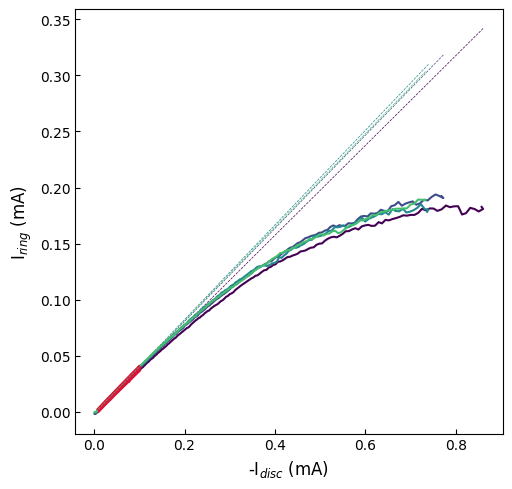

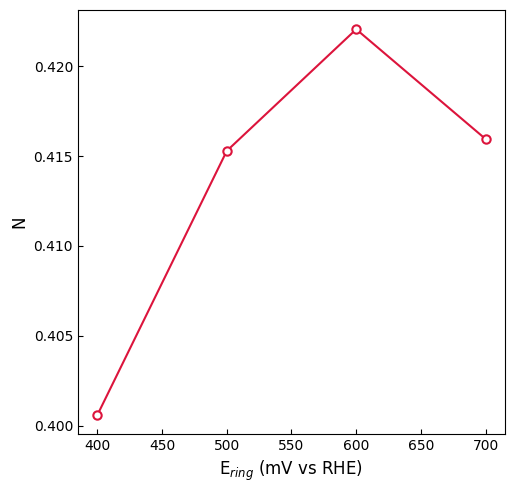

In [9]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# PARAMETERS
area = 0.2 * 0.2 * 3.14           # Geometrical area of the disc electrode
current_fit_range = (-0.1, -0.01) # Range to be used for the current fitting
color_map = "viridis"

# Selecting only the data in the cathodic branch
# Additional filters on the data should be placed here
final_df = final_df[final_df[branch]]

# Linear function that will be used to to the fitting
def linear(x, a, b):
    return ((a * x) + b)

# Colormap
cmap = plt.get_cmap(color_map)
n = len(final_df[id].unique())
color_list = cmap(np.linspace(0.0, 0.7, n))

# Conversion from Ag/AgCl electrode to RHE
def pH_shift(pH):
    return 0.222 + 0.047 + (0.05916 * pH)

# Dictionary with the pH shift for the various H2O contents of the electrolytes
shift_dict = {
    50: pH_shift(8.00),
    20: pH_shift(8.55),
    10: pH_shift(9.05),
    5: pH_shift(9.69)
}

plt.figure(figsize = (14/2.54, 14/2.54))

coll_eff_data = []

for i, cycle_id in enumerate(final_df[id].unique()):
    sub_df = final_df[final_df[id] == cycle_id].copy()

    # Find water content and applying potential shift
    w = sub_df.iloc[0][water]

    if w != np.nan:
        her_pot_shift = shift_dict[w]
        sub_df[pot] = sub_df[pot] + her_pot_shift

    # Range used for linear fitting
    coll_eff_interval = sub_df.loc[(sub_df[disc_curr] > current_fit_range[0]) & (sub_df[disc_curr] < current_fit_range[1])]

    x_data = -coll_eff_interval[disc_curr]
    y_data = coll_eff_interval[ring_curr]
    (coll_eff, res_curr), pcov = curve_fit(linear, x_data, y_data)

    # Extremes for the data plot
    x_fit_min = -sub_df[disc_curr].min()
    x_fit_max = -sub_df[disc_curr].max()
    y_fit_min = linear(x_fit_min, coll_eff, res_curr)
    y_fit_max = linear(x_fit_max, coll_eff, res_curr)

    label = f"N = {coll_eff:1.3f}"

    plt.plot(-sub_df[disc_curr], sub_df[ring_curr], color = color_list[i], lw = 1.5, label = label)
    plt.plot(-coll_eff_interval[disc_curr], coll_eff_interval[ring_curr], color = "crimson", lw = 2.5)
    plt.plot([x_fit_min, x_fit_max], [y_fit_min, y_fit_max], ls = "dashed", color = color_list[i], lw = 0.5)

    fit_dict = {
        "N": coll_eff,
        "I_res": res_curr,
        ring_pot: sub_df[ring_pot].mean()
    }

    coll_eff_data.append(fit_dict)

plt.xlabel("-I$_{disc}$ (mA)", fontsize = 12)
plt.ylabel("I$_{ring}$ (mA)", fontsize = 12)
plt.tick_params(axis = "both", direction = "in")

plt.show()

fit_df = pd.DataFrame(coll_eff_data)

plt.figure(figsize = (14/2.54, 14/2.54))
plt.plot(fit_df[ring_pot], fit_df["N"], color = "crimson", marker = "o", mec = "crimson", mfc = "white", lw = 1.5, mew = 1.5)
plt.xlabel("E$_{ring}$ (mV vs RHE)", fontsize = 12)
plt.ylabel("N", fontsize = 12)
plt.tick_params(axis = "both", direction = "in")

plt.show()


From the first graph, it can be seen that there is indeed a linear correlation between the two currents as long as they are low. As the current increases, a deviation from linearity appears due to hydrogen bubbles forming.

The second graph shows the different values of collection efficiency as a function of the ring potential applied. Considering that the theoretical maximum collection efficiency for this geometry is 0.424, it seems that +600 mV RHE is the proper potential to select for this analysis.

It is then possible to represent the voltammetric data and check that the current from the ring matches the current from the disc (after taking collection efficiency into account)

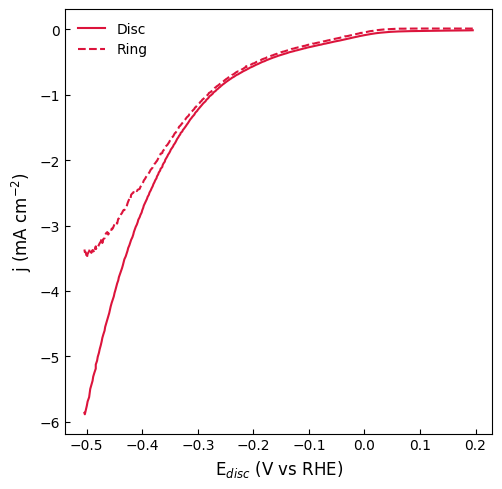

In [27]:
plt.figure(figsize = (14/2.54, 14/2.54))

cycle_df = final_df[final_df[ring_pot] == 600]
coll_eff = fit_df.loc[fit_df[ring_pot] == 600, "N"].values

x = cycle_df[pot] + pH_shift(8.00)
y1 = cycle_df[disc_curr] / area
y2 = -cycle_df[ring_curr] / (coll_eff * area)

plt.plot(x, y1, color = "crimson", label = "Disc")
plt.plot(x, y2, color = "crimson", label = "Ring", ls = "dashed")

plt.legend(frameon = False)
plt.xlabel("E$_{disc}$ (V vs RHE)", fontsize = 12)
plt.ylabel("j (mA cm$^{-2}$)", fontsize = 12)
plt.tick_params(axis = "both", direction = "in")

plt.show()